# Constant Opacity
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  12/07/2023          |
| Updated |  04/01/2024          |

See [Desmos](https://www.desmos.com/) for interactive plots of 
- [$T = P/\rho$](https://www.desmos.com/calculator/ptyevuziu7)
- [$\rho_\mathrm{mid}$](https://www.desmos.com/calculator/ubtsqj1ltb)
- [$\rho(\theta)$](https://www.desmos.com/calculator/marlugmhhr)

In code units,
\begin{align*}
  T(r, \theta) &= \frac{P(r, \theta)}{\rho} = \frac{P_0}{\rho_0}\left(\frac{r\sin\theta}{r_0}\right)^{-1/2}, \\
  \rho_\mathrm{mid}(r) &= \frac{\rho_0\left(\frac{r + r_0}{r_0}\right)^{-9/4}}{1 + \exp\left[-\mathrm{e}^\mathrm{e}\left(\frac{r - r_0}{r_0}\right)\right]}, \\
  \rho(r, \theta) &= \rho_\mathrm{mid}\exp\left[\frac{GMr}{P}\left(\frac{1}{\sqrt{r^2\sin^2\theta + r^2\cos^2\theta}} - \frac{1}{r\sin\theta}\right)\right], \\
                  &= \rho_\mathrm{mid}\exp\left[\frac{GM}{P}\left(1 - \frac{1}{\sin\theta}\right)\right]. \\
\end{align*}

## Midplane Temperature Profiles

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat
Reading dustkappa_constant.inp
Opacity at 0.50um :  21.839999999999996


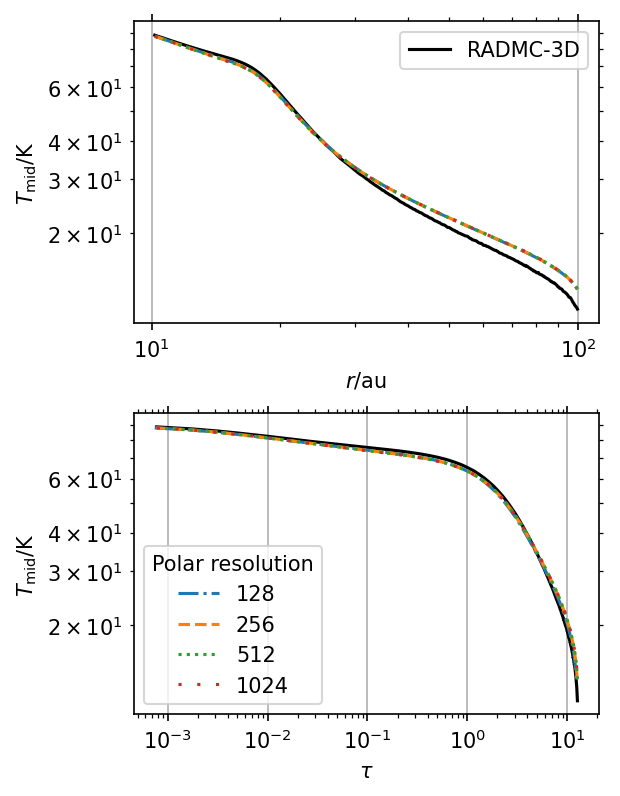

In [16]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions
rad2deg          = 180/np.pi           # [deg]

fig, axs = plt.subplots(nrows=2, figsize=(4, 6), dpi=150)
tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
data = analyze.readData(ddens=True, dtemp=True)
theta_deg = 90
j_mid_radmc = 256

data.getTau(wav=0.5) # tau = 1 surface
axs[0].plot(data.grid.x/natconst.au, data.dusttemp[:,j_mid_radmc,0,0], 'black',
            label='RADMC-3D')
axs[1].plot(data.taux[:,j_mid_radmc,0], data.dusttemp[:,j_mid_radmc,0,0], 'black')

base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'const_opac_raytrace'
runs = ['128nx2', '256nx2', '512nx2', '1024nx2']

for i, run in enumerate(runs):
    path = f'{base}/{problem_id}/implicit/heat/{run}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
           /athinput['mesh']['nx2']
    j_mid = int(theta_deg/rad2deg/dtheta)
    L_0 = athinput['radiation']['length_unit']
    T_0 = athinput['radiation']['T_unit']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
    dtau = athdf['Sigma_a_0'][0]*np.diff(athdf['x1f'])
    tau_field  = np.cumsum(dtau, axis=1)
    T_field = athdf['press'][0][j_mid]/athdf['rho'][0][j_mid]

    axs[0].plot(athdf['x1v']*L_0/natconst.au, T_field*T_0, tab_colors[i],
                ls=lss[i+1])
    axs[1].plot(tau_field[j_mid], T_field*T_0, tab_colors[i], ls=lss[i+1],
                label=f'{run[:-3]}')

# Format (sub)plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(ylabel=r'$T_\mathrm{mid}$/K', yscale='log', xscale='log',)
    ax.tick_params(axis='both', which='both', top=True, right=True)

axs[0].legend()
axs[0].set(xlabel=r'$r$/au')
axs[1].legend(title='Polar resolution')
axs[1].set(xlabel=r'$\tau$')
plt.subplots_adjust(hspace=0.3)